# TMDB Movie Analysis Pipeline (PySpark)

This notebook orchestrates the complete ETL and analysis pipeline for the TMDB Movie Dataset.
It leverages **PySpark** for scalable data processing and **Pandas/Matplotlib** for final visualization.

## Pipeline Steps
1.  **Fetch**: Retrieve data from TMDB API (with retries and logging).
2.  **Process**: Clean and transform JSON data into Parquet using PySpark.
3.  **Analyze**: Aggregate and query data using PySpark DSL.
4.  **Visualize**: Plot insights.

In [1]:
import os
import sys
import socketserver
from pathlib import Path

# --- PySpark on Windows Workaround ---
# PySpark 4.x on Windows references UnixStreamServer in accumulators.py 
# which causes an AttributeError. We patch it to use TCPServer (or a dummy) 
# to allow the module to import.
if os.name == 'nt' and not hasattr(socketserver, 'UnixStreamServer'):
    socketserver.UnixStreamServer = socketserver.TCPServer

# Add project root to path to allow importing src modules
project_root = Path("..").resolve()
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
import seaborn as sns

# Import our custom modules
from src.logger import setup_logger
from src.fetch_data import TMDBFetcher
from src.process_data import process_data
from src.analysis import MovieAnalyzer

# Configure Plotting Style
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

In [2]:
# Setup Spark Session
import os
import sys
from pathlib import Path
from pyspark.sql import SparkSession

# Add the project root to system path to import modules from src/
# In Docker, src is at /home/spark/src, and notebooks are at /home/spark/work
sys.path.append('/home/spark') 
# Fallback for local run if not in Docker structure
sys.path.append(str(Path.cwd().parent))

# Configuration
# Using local[*] mode - runs Spark locally within this container
# This is simpler and more stable for development/learning
MASTER_URL = "local[*]"
DATA_DIR = Path(os.getenv("DATA_DIR", "../data"))

print(f"Using Spark in Local Mode: {MASTER_URL}")
print(f"Data Directory: {DATA_DIR}")

# Create SparkSession in local mode
spark = SparkSession.builder \
    .appName("TMDB_Movie_Analysis") \
    .master(MASTER_URL) \
    .config("spark.sql.legacy.timeParserPolicy", "LEGACY") \
    .config("spark.driver.memory", "2g") \
    .getOrCreate()

print(f"Spark Session Created: {spark.sparkContext.appName}")
print(f"Spark Version: {spark.version}")

Using Spark in Local Mode: local[*]
Data Directory: /home/spark/data


Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
26/01/26 10:30:48 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
26/01/26 10:30:49 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


Spark Session Created: TMDB_Movie_Analysis
Spark Version: 4.0.1


## Step 1: Fetch Data (API)
We use the `TMDBFetcher` class to robustly download movie data. This handles retries for rate limits and saves the raw JSON to disk.

In [3]:
from src.fetch_data import TMDBFetcher

# Ensure API Key is set
# os.environ['TMDB_API_KEY'] = 'your_key_here' # Uncomment and set if not in .env

# IDs to fetch
movie_ids = [0, 299534, 19995, 140607, 299536, 597, 135397, 420818, 24428, 168259, 99861, 284054, 12445, 181808, 330457, 351286, 109445, 321612, 260513]

try:
    fetcher = TMDBFetcher()
    movies_data = fetcher.fetch_specific_movies(movie_ids)
    
    raw_output_path = DATA_DIR / "raw" / "movies.json"
    TMDBFetcher.save_raw_data(movies_data, raw_output_path)
    
except Exception as e:
    print(f"Error occurred: {e}")


INFO: Skipping movie ID 0 as it's invalid.
INFO: Fetching details for movie ID: 299534
INFO: Progress: 2/19 completed.
INFO: Fetching details for movie ID: 19995
INFO: Progress: 3/19 completed.
INFO: Fetching details for movie ID: 140607
INFO: Progress: 4/19 completed.
INFO: Fetching details for movie ID: 299536
INFO: Progress: 5/19 completed.
INFO: Fetching details for movie ID: 597
INFO: Progress: 6/19 completed.
INFO: Fetching details for movie ID: 135397
INFO: Progress: 7/19 completed.
INFO: Fetching details for movie ID: 420818
INFO: Progress: 8/19 completed.
INFO: Fetching details for movie ID: 24428
INFO: Progress: 9/19 completed.
INFO: Fetching details for movie ID: 168259
INFO: Progress: 10/19 completed.
INFO: Fetching details for movie ID: 99861
INFO: Progress: 11/19 completed.
INFO: Fetching details for movie ID: 284054
INFO: Progress: 12/19 completed.
INFO: Fetching details for movie ID: 12445
INFO: Progress: 13/19 completed.
INFO: Fetching details for movie ID: 181808
INFO

Saved 18 movies to /home/spark/data/raw/movies.json


## Step 2: Process Data (ETL)
We use PySpark to read the nested JSON, flatten it, clean data types, and compute metrics like ROI.
The result is saved as a columnar **Parquet** file.

In [4]:
from src.process_data import process_data

raw_path = str(DATA_DIR / "raw" / "movies.json")
processed_path = str(DATA_DIR / "processed" / "movies.parquet")

try:
    process_data(raw_path, processed_path, spark)
    print("Data processing complete.")
except Exception as e:
    print(f"Processing failed: {e}")

INFO: Loading data from /home/spark/data/raw/movies.json
INFO: Starting processing...                                                    
INFO: Writing parsed data to /home/spark/data/processed/movies.parquet...
26/01/26 10:31:12 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
INFO: Processing complete.                                                      


Data processing complete.


## Step 3: Analyze Data
We initialize the `MovieAnalyzer` which wraps PySpark queries. It computes aggregations on the cluster (simulated) and returns lightweight Pandas DataFrames for results.

In [5]:
from src.analysis import MovieAnalyzer

analyzer = MovieAnalyzer(spark)
analyzer.load_data(str(DATA_DIR / "processed" / "movies.parquet"))

# 1. Financial Stats
financials = analyzer.get_financial_stats()

INFO: Loading data from /home/spark/data/processed/movies.parquet
INFO: Loaded 18 movies.                                                         


In [6]:
print("--- Highest Revenue ---")
print(financials['top_revenue'])

--- Highest Revenue ---
                          title  revenue_musd
0                        Avatar   2923.706026
1             Avengers: Endgame   2799.439100
2                       Titanic   2264.162353
3  Star Wars: The Force Awakens   2068.223624
4        Avengers: Infinity War   2052.415039


In [7]:
print("\n--- Highest Budget ---")
print(financials['top_budget'])


--- Highest Budget ---
                          title  budget_musd
0             Avengers: Endgame        356.0
1      Star Wars: The Last Jedi        300.0
2        Avengers: Infinity War        300.0
3                 The Lion King        260.0
4  Star Wars: The Force Awakens        245.0


In [8]:
print("\n--- Highest Profit ---")
print(financials['top_profit'])


--- Highest Profit ---
                          title       profit
0                        Avatar  2686.706026
1             Avengers: Endgame  2443.439100
2                       Titanic  2064.162353
3  Star Wars: The Force Awakens  1823.223624
4        Avengers: Infinity War  1752.415039


In [9]:
print("\n--- Lowest Profit (Flops) ---")
print(financials['flops'])


--- Lowest Profit (Flops) ---
                            title       profit
0        Star Wars: The Last Jedi  1032.698830
1                   Incredibles 2  1043.225667
2            Beauty and the Beast  1106.115964
3                          Frozen  1124.219009
4  Jurassic World: Fallen Kingdom  1140.469037


In [10]:
print("\n--- Highest ROI (Budget >= 10M) ---")
print(financials['top_roi'])


--- Highest ROI (Budget >= 10M) ---
                                          title        roi
0                                        Avatar  12.336312
1                                       Titanic  11.320812
2                                Jurassic World  11.143583
3  Harry Potter and the Deathly Hallows: Part 2  10.732090
4                                     Frozen II   9.691223


In [11]:
print("\n--- Lowest ROI (Budget >= 10M) ---")
print(financials['flops_roi'])


--- Lowest ROI (Budget >= 10M) ---
                      title       roi
0  Star Wars: The Last Jedi  4.442329
1   Avengers: Age of Ultron  5.980441
2             Incredibles 2  6.216128
3             The Lion King  6.392388
4             Black Panther  6.749630


In [12]:
print("\n--- Most Voted Movies ---")
print(financials['most_voted'])


--- Most Voted Movies ---
                    title  vote_count
0            The Avengers       35399
1                  Avatar       33330
2  Avengers: Infinity War       31385
3       Avengers: Endgame       27170
4                 Titanic       26702


In [13]:
print("\n--- Highest Rated Movies (Votes >= 10) ---")
print(financials['highest_rated'])


--- Highest Rated Movies (Votes >= 10) ---
                                          title  vote_average
0                             Avengers: Endgame         8.200
1                        Avengers: Infinity War         8.200
2  Harry Potter and the Deathly Hallows: Part 2         8.081
3                                  The Avengers         7.920
4                                       Titanic         7.902


In [14]:
print("\n--- Highest Rated Movies (Votes >= 10) ---")
print(financials['highest_rated'])


--- Highest Rated Movies (Votes >= 10) ---
                                          title  vote_average
0                             Avengers: Endgame         8.200
1                        Avengers: Infinity War         8.200
2  Harry Potter and the Deathly Hallows: Part 2         8.081
3                                  The Avengers         7.920
4                                       Titanic         7.902


In [15]:
print("\n--- Lowest Rated Movies (Votes >= 10) ---")
print(financials['lowest_rated'])


--- Lowest Rated Movies (Votes >= 10) ---
                            title  vote_average
0  Jurassic World: Fallen Kingdom         6.535
1                  Jurassic World         6.700
2        Star Wars: The Last Jedi         6.760
3            Beauty and the Beast         6.968
4                   The Lion King         7.097


In [16]:
print("\n--- Most Popular Movies ---")
print(financials['most_popular'])


--- Most Popular Movies ---
                    title  popularity
0            The Avengers     82.8271
1                  Avatar     48.9819
2  Avengers: Infinity War     31.3200
3                 Titanic     30.5640
4                  Frozen     21.0553


## Step 4: Visualization
Using the aggregated stats from Step 3 to draw insights.

In [20]:
# 2. Specific Queries
specifics = analyzer.get_specific_movies()
print("\n--- Bruce Willis Sci-Fi ---")
print(specifics['bruce_willis_scifi'])


--- Bruce Willis Sci-Fi ---
Empty DataFrame
Columns: [title, vote_average, release_date]
Index: []


In [19]:

print("\n--- Uma Thurman & Quentin Tarantino ---")
print(specifics['uma_qt_collab'])


--- Uma Thurman & Quentin Tarantino ---
Empty DataFrame
Columns: [title, runtime, release_date]
Index: []


In [21]:
# 3. Franchise Analysis
stats, top_franchises = analyzer.analyze_franchises()
print("\n--- Franchise Stats ---")
print(stats)


--- Franchise Stats ---
              avg_revenue  avg_budget  avg_popularity  avg_rating
is_franchise                                                     
Franchise     1682.668411       218.0       21.621681     7.38825
Standalone    1765.139159       180.0       24.708000     7.43500


In [22]:
print("\n--- Top Franchises ---")
print(top_franchises)



--- Top Franchises ---
      belongs_to_collection  movie_count  total_revenue  avg_rating
0   The Avengers Collection            4    7776.073348      7.9050
1      Star Wars Collection            2    3400.922454      7.0065
2  Jurassic Park Collection            2    2982.006481      6.6175
3         Avatar Collection            1    2923.706026      7.6000
4         Frozen Collection            2    2727.902485      7.2425


In [23]:
# 4. Top Directors
print("\n--- Top Directors ---")
print(analyzer.analyze_directors())


--- Top Directors ---
        director  movie_count  total_revenue  avg_rating
0  James Cameron            2    5187.868379      7.7510
1  Anthony Russo            2    4851.854139      8.2000
2    Joss Whedon            2    2924.219209      7.6100
3   Jennifer Lee            2    2727.902485      7.2425
4    J.J. Abrams            1    2068.223624      7.2530


In [25]:
# 5. Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set_theme(style="ticks")
plt.rcParams['figure.figsize'] = (14, 8)

# Fetch Data needed for plots
genre_stats = analyzer.get_genre_stats()
yearly_stats = analyzer.get_yearly_trends()
all_movies = analyzer.get_all_movies_for_plot()


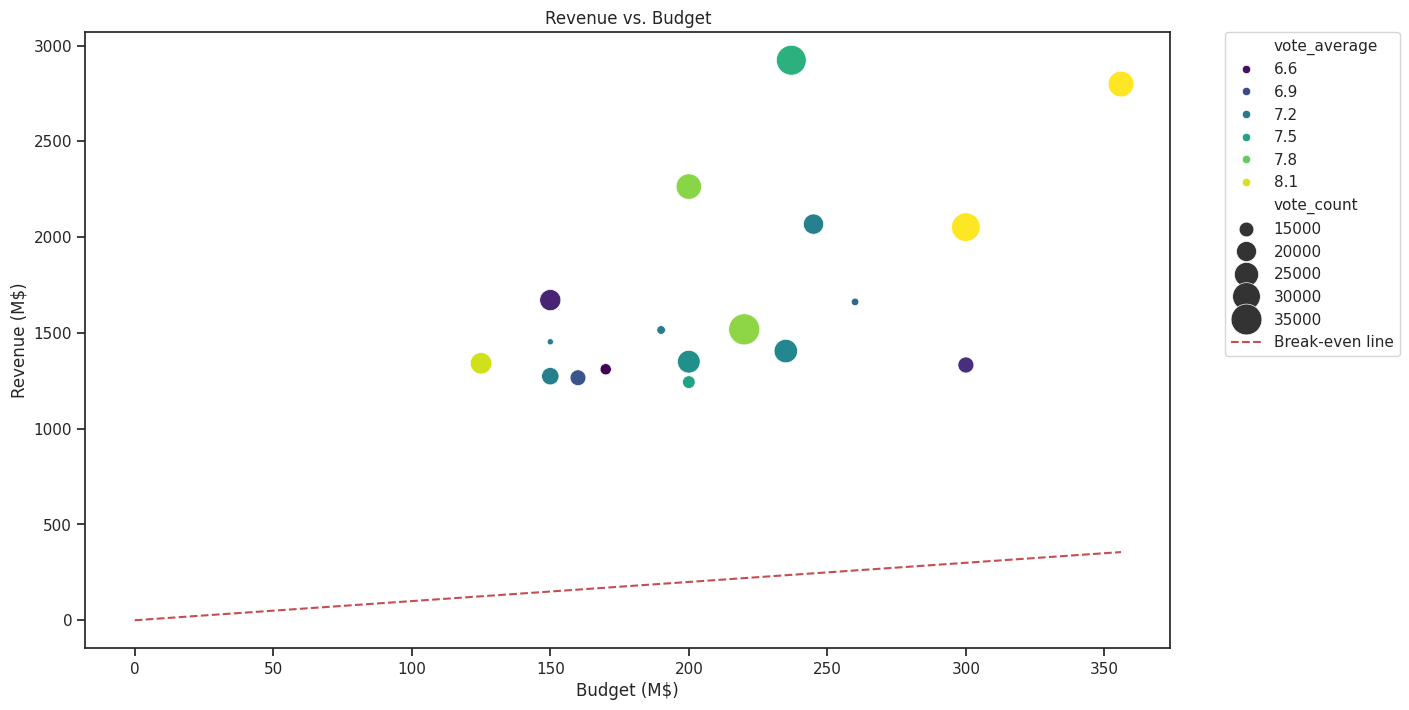

In [33]:
# A. Revenue vs. Budget (Scatter Plot)
plt.figure()
sns.scatterplot(data=all_movies, x="budget_musd", y="revenue_musd", size="vote_count", sizes=(20, 500), hue="vote_average", palette="viridis")
plt.title("Revenue vs. Budget")
plt.xlabel("Budget (M$)")
plt.ylabel("Revenue (M$)")
plt.plot([0, all_movies['budget_musd'].max()], [0, all_movies['budget_musd'].max()], 'r--', label='Break-even line') # Break-even line
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

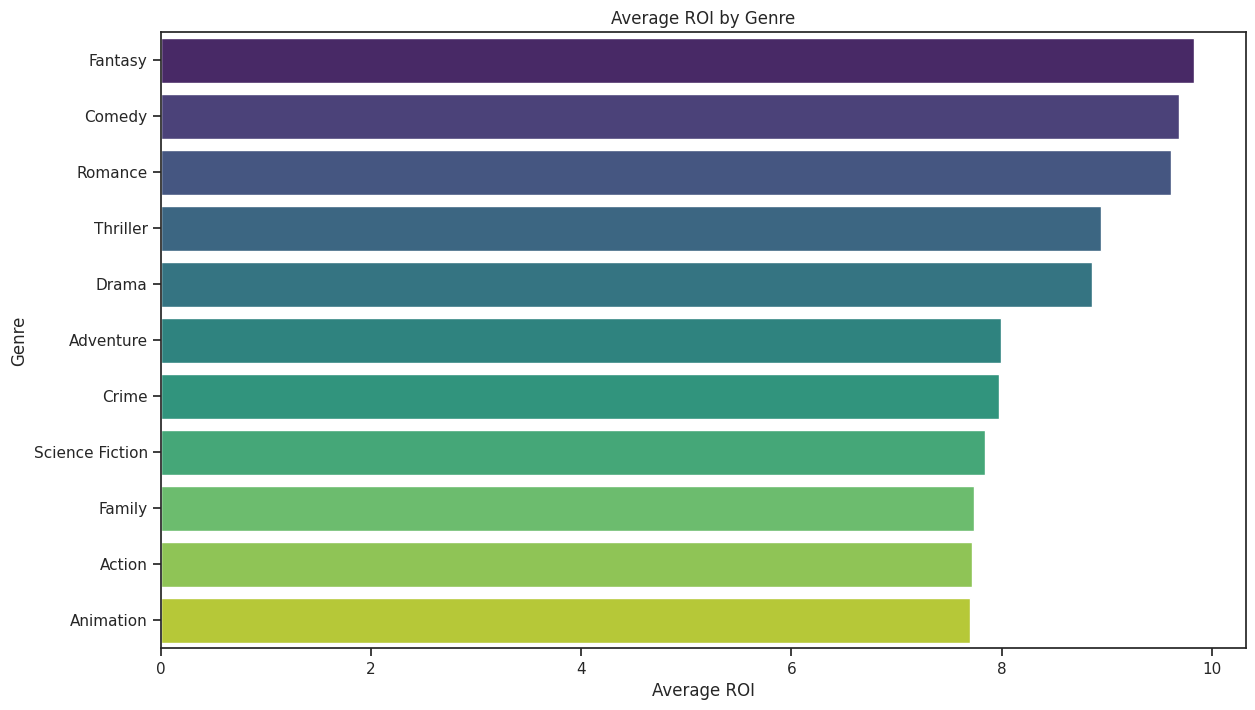

In [30]:
# B. ROI Distribution by Genre (Bar Plot)
plt.figure()
sns.barplot(data=genre_stats.sort_values(by="avg_roi", ascending=False), x="avg_roi", y="genre", hue="genre", palette="viridis", legend=False)
plt.title("Average ROI by Genre")
plt.xlabel("Average ROI")
plt.ylabel("Genre")
plt.show()

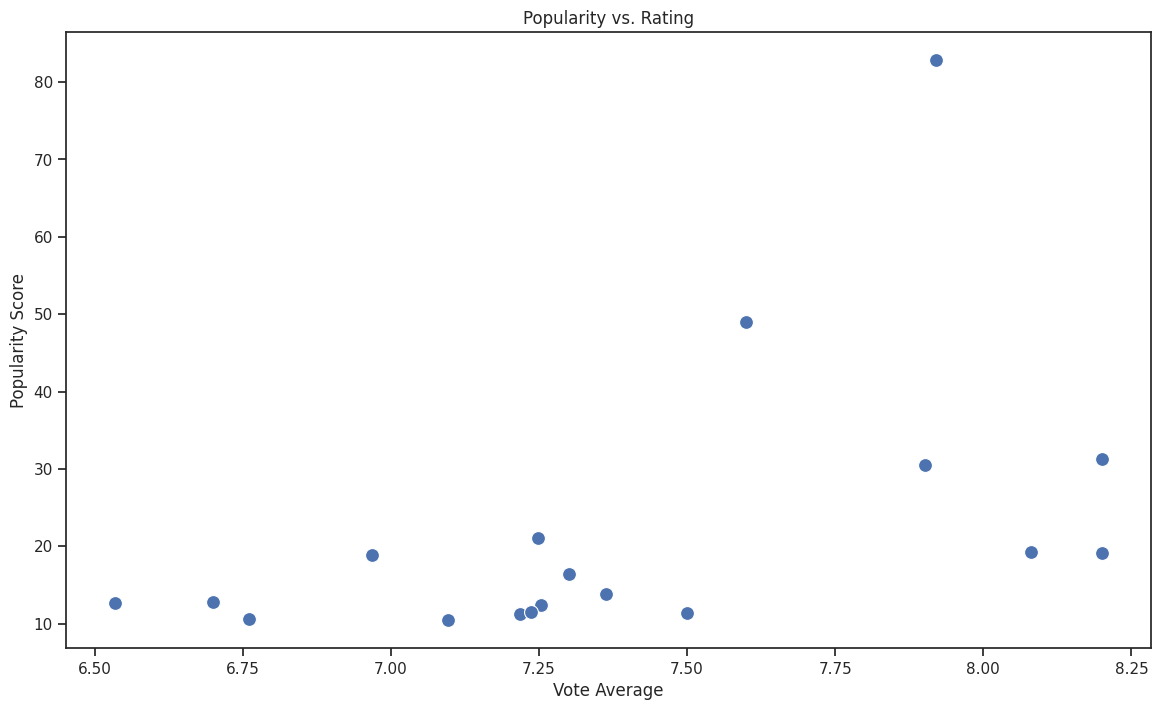

In [29]:
# C. Popularity vs. Rating (Scatter Plot)
plt.figure()
annotated = sns.scatterplot(data=all_movies, x="vote_average", y="popularity", s=100)
plt.title("Popularity vs. Rating")
plt.xlabel("Vote Average")
plt.ylabel("Popularity Score")
plt.show()

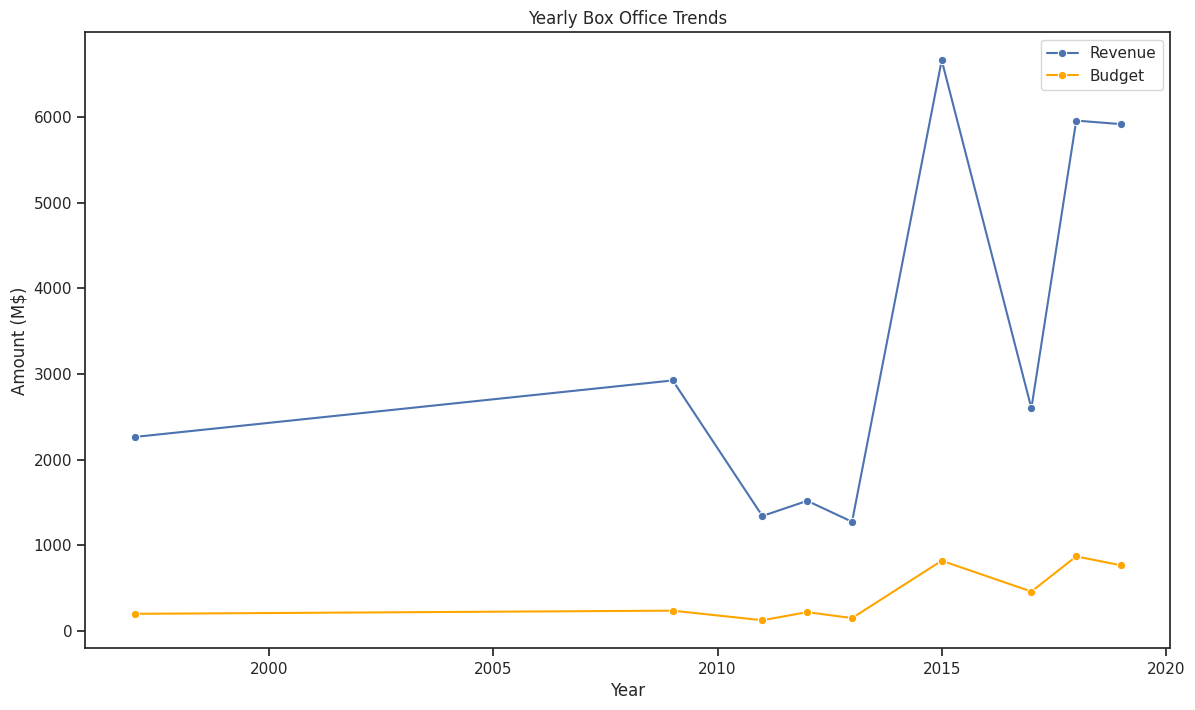

In [28]:
# D. Yearly Box Office Trends (Line Plot)
plt.figure()
sns.lineplot(data=yearly_stats, x="release_year", y="total_revenue", marker="o", label="Revenue")
sns.lineplot(data=yearly_stats, x="release_year", y="total_budget", marker="o", color="orange", label="Budget")
plt.title("Yearly Box Office Trends")
plt.xlabel("Year")
plt.ylabel("Amount (M$)")
plt.legend()
plt.show()

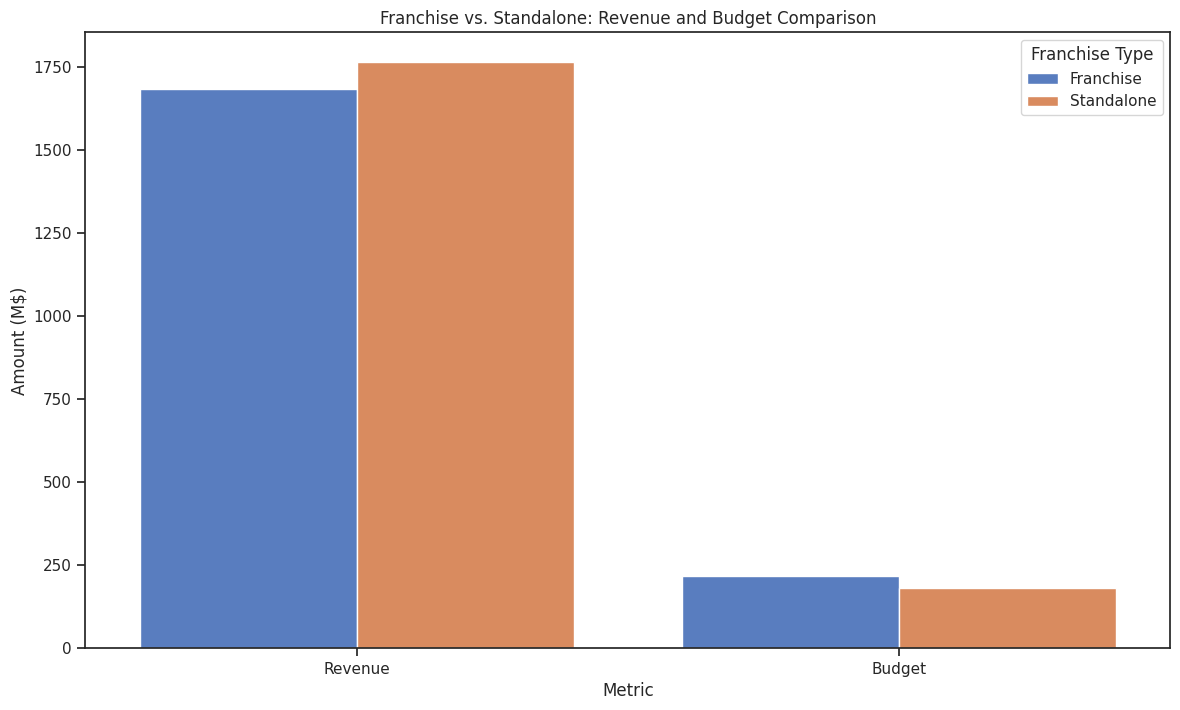

In [36]:
# E. Franchise vs Standalone (Side-by-Side Bar Plot)
plt.figure()
stats_reset = stats.reset_index()

# Melt the dataframe to have Revenue and Budget in one column
stats_melted = stats_reset.melt(
    id_vars="is_franchise", 
    value_vars=["avg_revenue", "avg_budget"], 
    var_name="Metric", 
    value_name="Amount (M$)"
)

# Rename the metrics for better legend readability
stats_melted["Metric"] = stats_melted["Metric"].replace({
    "avg_revenue": "Revenue", 
    "avg_budget": "Budget"
})

# Create grouped bar chart - Swapped x and hue to match the desired layout
sns.barplot(data=stats_melted, x="Metric", y="Amount (M$)", hue="is_franchise", palette="muted")

plt.title("Franchise vs. Standalone: Revenue and Budget Comparison")
plt.ylabel("Amount (M$)")
plt.xlabel("Metric")
plt.legend(title="Franchise Type")
plt.show()